In [1]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True#False
plt.rcParams['axes.spines.right'] = True#False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

%load_ext autoreload
%autoreload 2
sys.path.append('/Users/belugawhale/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18

def load_data(path, fname='interp_between_1.npy'):
    wavelength, flux, err = load_binned_data(os.path.join(path,fname))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced2')

flare_mask = np.load('/Users/belugawhale/Documents/AUMic/flare_mask.npy',
                     allow_pickle=True)

parula = np.load('/Users/belugawhale/parula_colors.npy')
distance = (9.72*units.pc).to(units.cm)

## Flares in the 30s data

In [2]:
w30, f30, e30, t30, o30 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced')
w20, f20, e20, t20, o20 = load_data(path='/Users/belugawhale/Documents/AUMic/30s/reduced2')

fwc = FlaresWithCOS(wavelength=np.append(w30, w20, axis=0), 
                    flux=np.append(f30, f20, axis=0),
                    flux_err=np.append(e30, e20, axis=0), 
                    time=np.append(t30, t20)-t30[0], 
                    orbit=np.append(o30, o20+5))

fwc.load_line_table(path='/Users/belugawhale/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/belugawhale/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')
fwc.line_table.add_row(['FeXII', 1241.98, -50, 50, 1])
for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

In [3]:
%load_ext autoreload
%autoreload 2
from plot_utils import make_tworow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def check_dimming(ion='FeXXI', alpha=0.4, plot_highlight=True,
                  colors=['#666666', '#569799', '#F8B663', '#569799'], ax=None,
                  legend=False):
    
    t = fwc.time.value
    q = (t < 1e6) & (fwc.orbit==3)
    pre = (t < 1e6) & (fwc.orbit==3) & (t>17090) & (t<17600)
    aft = (t < 1e6) & (fwc.orbit==3) & (t>18300) & (t<19230)

    if ax is None:
        fig, ax = plt.subplots(figsize=(14,4))
        ax.set_xlabel('Time - T$_0$ [s]')
        ax.set_ylabel('{} Normalized Flux'.format(ion))

    ax.errorbar(t[q][:-1],
                 fwc.width_table[ion].data[q][:-1]/np.nanmedian(fwc.width_table[ion].data[q]),
                 yerr=fwc.error_table[ion].data[q][:-1],
                 marker='o', color=COLOR, zorder=3)

    if plot_highlight:
        fb = (t < 1e6) & (flare_mask[2][3]>0) & (t>12500)
        ax.axvspan(t[fb][0], t[fb][-2], 0, 2, label='Flare C',
                    alpha=alpha+0.2, lw=0, color=colors[0])
        
        ax.axvspan(t[pre][0], t[pre][-1], alpha=alpha, lw=0, 
                    color=colors[1], label='pre-flare')

        fb = (t < 1e6) & (flare_mask[2][4]>0) & (t>12500)
        ax.axvspan(t[fb][0], t[fb][-2], 0, 2, label='Flare D', alpha=alpha+0.2, lw=0,
                    color=colors[2])

        ax.axvspan(t[aft][0], t[aft][-1], color=colors[3], label='post-flare',
                     alpha=alpha, lw=0)

        ax.hlines(1, t[q][0]-100, t[q][-1]+100, color='#861F3C', linestyle='--',
                   lw=3)

    print('pre-flare: ', np.nanmedian(fwc.width_table[ion].data[pre]),
                         np.nanstd(fwc.width_table[ion].data[pre]))
    print('post-flare: ', np.nanmedian(fwc.width_table[ion].data[aft]),
                          np.nanstd(fwc.width_table[ion].data[aft]))

    ax.set_xlim(t[q][0], t[q][-2])
    #plt.errorbar(t[fb][:-1],
    #             fwc.width_table[ion].data[fb][:-1]/np.nanmedian(fwc.width_table[ion].data[oof]),
    #             yerr=fwc.error_table[ion].data[fb][:-1],
    #             marker='o',  color=parula[190], zorder=3, label='Flare C')

    if legend and plot_highlight:
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=4, mode="expand", borderaxespad=0.)
    
    
    return ax


pre-flare:  6.090862130033396e-13 1.2453384484763787e-13
post-flare:  4.729824581333493e-13 1.0468103134818493e-13


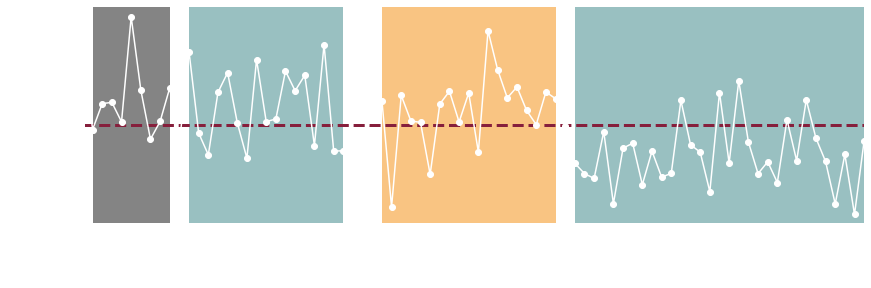

In [163]:
f = check_dimming(alpha=0.6, colors=['#666666', '#569799', '#F8B663', '#569799'], 
                 plot_highlight=True)
#plt.savefig('/Users/belugawhale/Desktop/fe_XXI_flareD.png', transparent=True,
#            dpi=300, rasterize=True, bbox_inches='tight')

pre-flare:  1.3098721581172395e-13 5.71607840441294e-14
post-flare:  1.433425435657012e-13 5.994912743360278e-14
pre-flare:  6.177051081775954e-13 2.0338323558160359e-13
post-flare:  4.728783243693647e-13 1.88032648309437e-13
pre-flare:  6.090862130033396e-13 1.2453384484763787e-13
post-flare:  4.729824581333493e-13 1.0468103134818493e-13


/var/folders/9s/jb487nv52hs8n0q5ftmb1lk80000gn/T/ipykernel_19853/451334250.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/Users/belugawhale/Documents/AUMic/paper/iron_dimming.pdf',


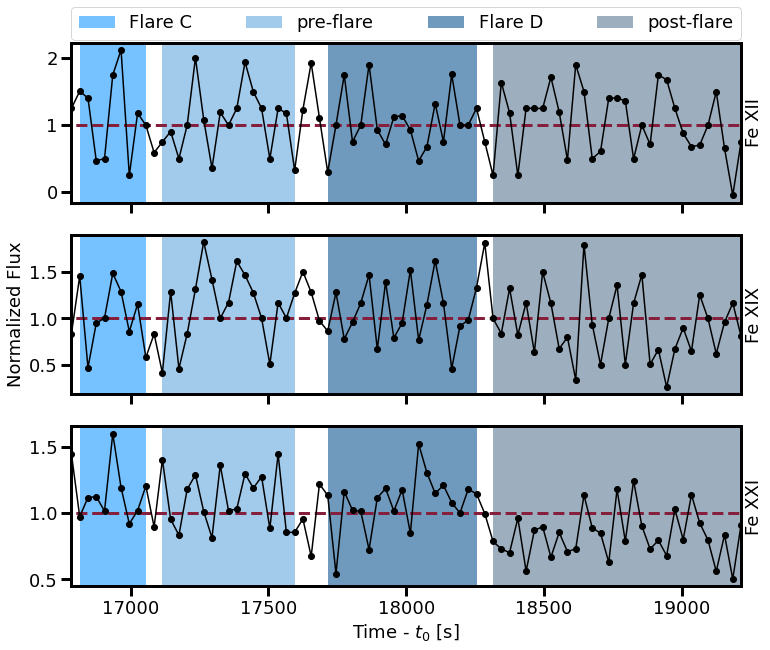

In [5]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=1, nrows=3, figsize=(12,10),
                                  sharex=True)
fig.set_facecolor('w')
colors = ['#1b98ff', '#187ccf', '#105791', '#0b395e']
check_dimming(ion='FeXII', ax=ax1, legend=True, colors=colors)
check_dimming(ion='FeXIX', ax=ax2, colors=colors)
check_dimming(ion='FeXXI', ax=ax3, colors=colors)
ax3.set_xlabel('Time - $t_0$ [s]')
ax2.set_ylabel('Normalized Flux')

irons = ['Fe XII', 'Fe XIX', 'Fe XXI']
for i,ax in enumerate([ax1, ax2, ax3]):
    twin1 = ax.twinx()
    twin1.set_ylabel(irons[i])
    twin1.set_yticks([])
    ax.set_rasterized(True)
    twin1.set_rasterized(True)
plt.savefig('/Users/belugawhale/Documents/AUMic/paper/iron_dimming.pdf',
            rasterize=True,  dpi=300)